In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [9]:
data = read_text("/content/drive/MyDrive/machine translation/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #3807493 

In [10]:
deu_eng = deu_eng[:50000,:2]

In [11]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["I'm giving up smoking.", 'Ich höre mit dem Rauchen auf.'],
       ["I'm glad I was nearby.",
        'Ich bin froh, dass ich in der Nähe war.'],
       ["I'm glad Tom has gone.", 'Ich bin froh, dass Tom weg ist.']],
      dtype='<U537')

In [12]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist']],
      dtype='<U537')

In [13]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['im giving up smoking', 'ich höre mit dem rauchen auf'],
       ['im glad i was nearby', 'ich bin froh dass ich in der nähe war'],
       ['im glad tom has gone', 'ich bin froh dass tom weg ist']],
      dtype='<U537')

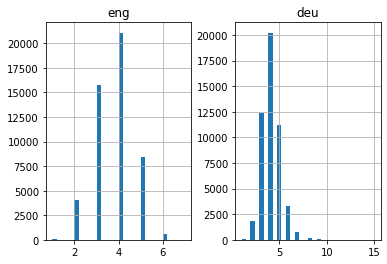

In [14]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [16]:
np.max(eng_l), np.max(deu_l)

(7, 15)

In [17]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [22]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [19]:
eng_tokenizer.word_index

{'tom': 1,
 'i': 2,
 'you': 3,
 'is': 4,
 'a': 5,
 'it': 6,
 'the': 7,
 'to': 8,
 'me': 9,
 'im': 10,
 'he': 11,
 'do': 12,
 'that': 13,
 'was': 14,
 'this': 15,
 'my': 16,
 'are': 17,
 'we': 18,
 'dont': 19,
 'have': 20,
 'your': 21,
 'did': 22,
 'like': 23,
 'its': 24,
 'can': 25,
 'youre': 26,
 'not': 27,
 'be': 28,
 'go': 29,
 'in': 30,
 'what': 31,
 'were': 32,
 'here': 33,
 'she': 34,
 'know': 35,
 'they': 36,
 'ill': 37,
 'want': 38,
 'very': 39,
 'now': 40,
 'how': 41,
 'on': 42,
 'cant': 43,
 'has': 44,
 'up': 45,
 'for': 46,
 'get': 47,
 'thats': 48,
 'need': 49,
 'no': 50,
 'at': 51,
 'toms': 52,
 'come': 53,
 'isnt': 54,
 'of': 55,
 'why': 56,
 'him': 57,
 'good': 58,
 'who': 59,
 'help': 60,
 'one': 61,
 'out': 62,
 'will': 63,
 'his': 64,
 'us': 65,
 'too': 66,
 'all': 67,
 'please': 68,
 'just': 69,
 'love': 70,
 'there': 71,
 'got': 72,
 'home': 73,
 'well': 74,
 'with': 75,
 'didnt': 76,
 'see': 77,
 'mary': 78,
 'am': 79,
 'stop': 80,
 'hes': 81,
 'look': 82,
 'car': 

In [21]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size) 

Deutch Vocabulary Size: 10329


In [23]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [24]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [25]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [26]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [27]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [28]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
filename = 'model.h1.19-03-21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 41s 95ms/step - loss: 4.3484 - val_loss: 2.8379

Epoch 00001: val_loss improved from inf to 2.83785, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 2/30
63/63 [==============================] - 5s 72ms/step - loss: 2.7819 - val_loss: 2.7306

Epoch 00002: val_loss improved from 2.83785 to 2.73057, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 2.6181 - val_loss: 2.5367

Epoch 00003: val_loss improved from 2.73057 to 2.53671, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 4/30
63/63 [==============================] - 5s 74ms/step - loss: 2.4307 - val_loss: 2.4140

Epoch 00004: val_loss improved from 2.53671 to 2.41404, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 5/30
63/63 [==============================] - 5s 75ms/step - loss: 2.2771 - val_loss: 2.2816

Epoch 00005: val_loss improved from 2.41404 to 2.28157, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 6/30
63/63 [==============================] - 5s 74ms/step - loss: 2.1299 - val_loss: 2.1885

Epoch 00006: val_loss improved from 2.28157 to 2.18846, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 2.0026 - val_loss: 2.1048

Epoch 00007: val_loss improved from 2.18846 to 2.10478, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 8/30
63/63 [==============================] - 5s 74ms/step - loss: 1.8921 - val_loss: 2.0295

Epoch 00008: val_loss improved from 2.10478 to 2.02954, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 9/30
63/63 [==============================] - 5s 76ms/step - loss: 1.7808 - val_loss: 1.9679

Epoch 00009: val_loss improved from 2.02954 to 1.96787, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 10/30
63/63 [==============================] - 5s 76ms/step - loss: 1.6705 - val_loss: 1.8896

Epoch 00010: val_loss improved from 1.96787 to 1.88957, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 11/30
63/63 [==============================] - 5s 77ms/step - loss: 1.5750 - val_loss: 1.8066

Epoch 00011: val_loss improved from 1.88957 to 1.80657, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 12/30
63/63 [==============================] - 5s 76ms/step - loss: 1.4718 - val_loss: 1.7469

Epoch 00012: val_loss improved from 1.80657 to 1.74695, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 13/30
63/63 [==============================] - 5s 77ms/step - loss: 1.3818 - val_loss: 1.6989

Epoch 00013: val_loss improved from 1.74695 to 1.69889, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 14/30
63/63 [==============================] - 5s 77ms/step - loss: 1.2967 - val_loss: 1.6460

Epoch 00014: val_loss improved from 1.69889 to 1.64597, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 15/30
63/63 [==============================] - 5s 76ms/step - loss: 1.2194 - val_loss: 1.6084

Epoch 00015: val_loss improved from 1.64597 to 1.60839, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 16/30
63/63 [==============================] - 5s 77ms/step - loss: 1.1357 - val_loss: 1.5708

Epoch 00016: val_loss improved from 1.60839 to 1.57083, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 17/30
63/63 [==============================] - 5s 77ms/step - loss: 1.0624 - val_loss: 1.5316

Epoch 00017: val_loss improved from 1.57083 to 1.53156, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 18/30
63/63 [==============================] - 5s 78ms/step - loss: 0.9895 - val_loss: 1.4955

Epoch 00018: val_loss improved from 1.53156 to 1.49552, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 19/30
63/63 [==============================] - 5s 77ms/step - loss: 0.9249 - val_loss: 1.4724

Epoch 00019: val_loss improved from 1.49552 to 1.47239, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 20/30
63/63 [==============================] - 5s 78ms/step - loss: 0.8574 - val_loss: 1.4479

Epoch 00020: val_loss improved from 1.47239 to 1.44793, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 21/30
63/63 [==============================] - 5s 78ms/step - loss: 0.7967 - val_loss: 1.4308

Epoch 00021: val_loss improved from 1.44793 to 1.43081, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 22/30
63/63 [==============================] - 5s 78ms/step - loss: 0.7486 - val_loss: 1.4098

Epoch 00022: val_loss improved from 1.43081 to 1.40980, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 23/30
63/63 [==============================] - 5s 77ms/step - loss: 0.6883 - val_loss: 1.3865

Epoch 00023: val_loss improved from 1.40980 to 1.38650, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 24/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6378 - val_loss: 1.3678

Epoch 00024: val_loss improved from 1.38650 to 1.36777, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 25/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5850 - val_loss: 1.3594

Epoch 00025: val_loss improved from 1.36777 to 1.35944, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 26/30
63/63 [==============================] - 5s 77ms/step - loss: 0.5406 - val_loss: 1.3516

Epoch 00026: val_loss improved from 1.35944 to 1.35163, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 27/30
63/63 [==============================] - 5s 78ms/step - loss: 0.4970 - val_loss: 1.3453

Epoch 00027: val_loss improved from 1.35163 to 1.34531, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 28/30
63/63 [==============================] - 5s 76ms/step - loss: 0.4583 - val_loss: 1.3274

Epoch 00028: val_loss improved from 1.34531 to 1.32735, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 29/30
63/63 [==============================] - 5s 77ms/step - loss: 0.4155 - val_loss: 1.3219

Epoch 00029: val_loss improved from 1.32735 to 1.32188, saving model to model.h1.19-03-21


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


INFO:tensorflow:Assets written to: model.h1.19-03-21/assets


Epoch 30/30
63/63 [==============================] - 5s 76ms/step - loss: 0.3801 - val_loss: 1.3354

Epoch 00030: val_loss did not improve from 1.32188


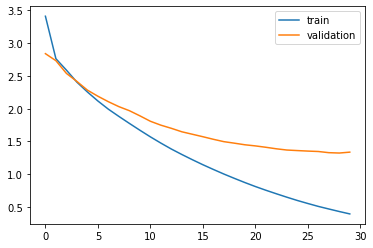

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [32]:
#model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
preds.shape

(10000, 8)

In [35]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [36]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if (t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))


In [37]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(15)

,actual,predicted
241,tom has a car,tom has a car
6150,they cannot stop me,you cant stop me
1765,dont be sad,dont cry
9738,my heart was racing,my life was racing
6722,i dont like liars,i dont like hungry
4213,he looked well,he got well
1454,ill bring it back,ill be it tomorrow
8758,why did you move out,why did you run
708,tom is undeterred,tom is available
7856,we know what you did,we know what you did
